# Проект для «Викишоп»

## Описание проекта
Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучим модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

Построим модель со значением метрики качества *F1* не меньше 0.75. 

## План работы

1.	Загрузим и подготовим данные.
2.	Обучим разные модели.
3.	Сделаем выводы.

Для выполнения проекта применять *BERT* необязательно.

## Описание данных

-	`text` — содержит текст комментария

Целевой признак:
-    `toxic`

Данные находятся в файле: `toxic_comments.csv` 

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import warnings
warnings.filterwarnings('ignore')

<!-- Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак. -->

## Подготовка

In [3]:
import sys
!{sys.executable} -m pip install spacy

!{sys.executable} -m spacy download en

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     |████████████████████████████████| 13.9 MB 1.3 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords as nltk_stopwords
nltk.download('wordnet')
nltk.download('stopwords')
import re
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
import spacy
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
toxic_comments = pd.read_csv('/datasets/toxic_comments.csv')
display(toxic_comments.head(10).style.background_gradient(cmap='Blues', axis=0))

,Unnamed: 0,text,toxic
0,0,"Explanation Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,3,""" More I can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know. There appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,4,"You, sir, are my hero. Any chance you remember what page that's on?",0
5,5,""" Congratulations from me as well, use the tools well. · talk """,0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,"Your vandalism to the Matt Shirvington article has been reverted. Please don't do it again, or you will be banned.",0
8,8,"Sorry if the word 'nonsense' was offensive to you. Anyway, I'm not intending to write anything in the article(wow they would jump on me for vandalism), I'm merely requesting that it be more encyclopedic so one can use it for school as a reference. I have been to the selective breeding page but it's almost a stub. It points to 'animal breeding' which is a short messy article that gives you no info. There must be someone around with expertise in eugenics? 93.161.107.169",0
9,9,alignment on this subject and which are contrary to those of DuLithgow,0


In [6]:
toxic_comments.drop('Unnamed: 0', axis= 1 , inplace= True )

In [7]:
display(toxic_comments.head(10).style.background_gradient(cmap='Blues', axis=0))

,text,toxic
0,"Explanation Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,""" More I can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know. There appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,"You, sir, are my hero. Any chance you remember what page that's on?",0
5,""" Congratulations from me as well, use the tools well. · talk """,0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,"Your vandalism to the Matt Shirvington article has been reverted. Please don't do it again, or you will be banned.",0
8,"Sorry if the word 'nonsense' was offensive to you. Anyway, I'm not intending to write anything in the article(wow they would jump on me for vandalism), I'm merely requesting that it be more encyclopedic so one can use it for school as a reference. I have been to the selective breeding page but it's almost a stub. It points to 'animal breeding' which is a short messy article that gives you no info. There must be someone around with expertise in eugenics? 93.161.107.169",0
9,alignment on this subject and which are contrary to those of DuLithgow,0


In [8]:
toxic_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [9]:
print('\u001b[38;5;19m','Количество дубликатов = ', toxic_comments.duplicated().sum(), '\u001b[0m')

 Количество дубликатов =  0 


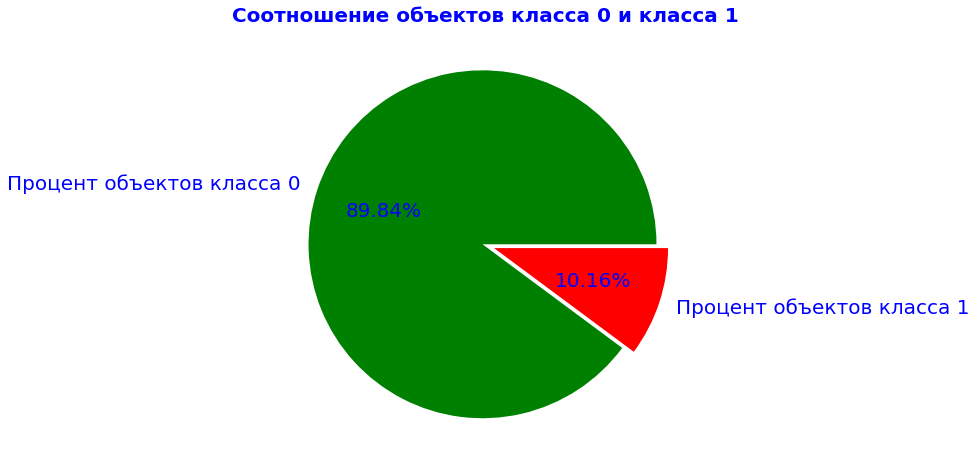

In [10]:
data = [len(toxic_comments[toxic_comments['toxic'] == 0]), len(toxic_comments[toxic_comments['toxic'] == 1])]
labels = ['Процент объектов класса 0', 'Процент объектов класса 1']
plt.figure(figsize=(8,8))
plt.rc('font', size= 20 ) 

fbcolor = ["green", "red"]

explode = [0.02, 0.05]

plt.pie(data, labels = labels, explode = explode, colors = fbcolor, autopct='%.2f%%', textprops={'color':"b"})
plt.title('Соотношение объектов класса 0 и класса 1',
          fontsize=20, fontweight="bold", color='blue')
plt.show() 

***Подготовим данные для векторизации***

In [11]:
def lemmatize(text):
    doc = nlp(text)
    lemmatized_output = " ".join([token.lemma_ for token in doc])
    return lemmatized_output

In [12]:
def clear_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z+\' ]', ' ', text)
    return " ".join(text.split())

In [13]:
from tqdm.notebook import tqdm
tqdm.pandas()

toxic_comments['lemm_text'] = toxic_comments['text'].apply(clear_text)
toxic_comments['lemm_text'] = toxic_comments['lemm_text'].progress_apply(lemmatize)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [14]:
stopwords = set(nltk_stopwords.words('english'))

In [15]:
display(toxic_comments.head(10).style.background_gradient(cmap='Blues', axis=0))

,text,toxic,lemm_text
0,"Explanation Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,explanation why the edit make under my username hardcore metallica fan be revert they be not vandalism just closure on some gas after I vote at new york doll fac and please do not remove the template from the talk page since I be retire now
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,d'aww he match this background colour I be seemingly stuck with thank talk january utc
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,hey man I be really not try to edit war it be just that this guy be constantly remove relevant information and talk to I through edit instead of my talk page he seem to care more about the formatting than the actual info
3,""" More I can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know. There appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,more I can not make any real suggestion on improvement I wonder if the section statistic should be later on or a subsection of type of accident I think the reference may need tidy so that they be all in the exact same format ie date format etc I can do that later on if no one else do first if you have any preference for format style on reference or want to do it yourself please let I know there appear to be a backlog on article for review so I guess there may be a delay until a reviewer turn up it be list in the relevant form eg wikipedia good article nomination transport
4,"You, sir, are my hero. Any chance you remember what page that's on?",0,you sir be my hero any chance you remember what page that be on
5,""" Congratulations from me as well, use the tools well. · talk """,0,congratulation from I as well use the tool well talk
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,cocksucker before you piss around on my work
7,"Your vandalism to the Matt Shirvington article has been reverted. Please don't do it again, or you will be banned.",0,your vandalism to the matt shirvington article have be revert please do not do it again or you will be ban
8,"Sorry if the word 'nonsense' was offensive to you. Anyway, I'm not intending to write anything in the article(wow they would jump on me for vandalism), I'm merely requesting that it be more encyclopedic so one can use it for school as a reference. I have been to the selective breeding page but it's almost a stub. It points to 'animal breeding' which is a short messy article that gives you no info. There must be someone around with expertise in eugenics? 93.161.107.169",0,sorry if the word ' nonsense ' be offensive to you anyway I be not intend to write anything in the article wow they would jump on I for vandalism I be merely request that it be more encyclopedic so one can use it for school as a reference I have be to the selective breeding page but it be almost a stub it point to ' animal breeding ' which be a short messy article that give you no info there must be someone around with expertise in eugenic
9,alignment on this subject and which are contrary to those of DuLithgow,0,alignm

***Разделим данные на тренировочную и тестовую выборки***

In [16]:
X_train, X_test, y_train, y_test = train_test_split(toxic_comments['lemm_text'], toxic_comments['toxic'], test_size=0.1, random_state=42)

In [17]:
print('\u001b[38;5;19m','Размер тренировочного корпуса = ', len(X_train), '\u001b[0m')
print('\u001b[38;5;19m','Размер тестового корпуса = ', len(X_test), '\u001b[0m')

 Размер тренировочного корпуса =  143362 
 Размер тестового корпуса =  15930 


***Проведём векторизацию корпусов***

In [18]:
tf_idf_vec = TfidfVectorizer(ngram_range=(1,1), stop_words=stopwords, min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1, smooth_idf=1, sublinear_tf=1 )

In [19]:
X_train_vec = tf_idf_vec.fit_transform(X_train)
X_test_vec = tf_idf_vec.transform(X_test)

In [20]:
print('\u001b[38;5;19m','Размер тренировочного датасета = ', X_train_vec.shape, '\u001b[0m')
print('\u001b[38;5;19m','Размер тестового датасета = ', X_test_vec.shape, '\u001b[0m')

 Размер тренировочного датасета =  (143362, 39425) 
 Размер тестового датасета =  (15930, 39425) 


## Обучение

### Логистическая регрессия

In [21]:
pipe = Pipeline([
    (
    ('model', LogisticRegression(random_state=42, solver='liblinear', max_iter=1000))
    )
    ])

param_grid = [
        {
            'model': [LogisticRegression(random_state=42, solver='liblinear')],
            'model__penalty' : ['l1', 'l2'],
            'model__C': list(range(10,15,1))
        }
]
clf_lrm = GridSearchCV(pipe, param_grid=param_grid, scoring='f1', cv=3, verbose=True, n_jobs=-1)
clf_lrm.fit(X_train_vec, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('model',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=42,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid=[{'model': [LogisticRegression(C=13, random_state=42,
                                                       solver='liblinear')],
                          'model__C': [10, 11, 12, 13, 14],
                          'model__penalty': ['l1', 'l2']}],
             scoring='f1', verbose=True)

In [22]:
print('\u001b[38;5;19m','Наилучший показатель f1 на кросс-валидации = ', round(clf_lrm.best_score_, 4), '\u001b[0m')
print('\u001b[38;5;19m','Параметр регуляризации для лучшей модели = ', clf_lrm.best_params_, '\u001b[0m')

 Наилучший показатель f1 на кросс-валидации =  0.7795 
 Параметр регуляризации для лучшей модели =  {'model': LogisticRegression(C=13, random_state=42, solver='liblinear'), 'model__C': 13, 'model__penalty': 'l2'} 


### LinearSVC

In [23]:
pipe = Pipeline([
    (
    ('model', LinearSVC(random_state=42, max_iter=1000))
    )
    ])

param_grid = [
        {
            'model': [LinearSVC(random_state=42)],
            'model__penalty' : ['l1', 'l2'],
            'model__C': list(range(15,20,1))
        }
]
clf_lsvc = GridSearchCV(pipe, param_grid=param_grid, scoring='f1', cv=3, verbose=True, n_jobs=-1)
clf_lsvc.fit(X_train_vec, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('model', LinearSVC(random_state=42))]),
             n_jobs=-1,
             param_grid=[{'model': [LinearSVC(C=15, random_state=42)],
                          'model__C': [15, 16, 17, 18, 19],
                          'model__penalty': ['l1', 'l2']}],
             scoring='f1', verbose=True)

In [24]:
print('\u001b[38;5;19m','Наилучший показатель f1 на кросс-валидации = ', round(clf_lsvc.best_score_, 4), '\u001b[0m')
print('\u001b[38;5;19m','Параметр регуляризации для лучшей модели = ', clf_lsvc.best_params_, '\u001b[0m')

 Наилучший показатель f1 на кросс-валидации =  0.7396 
 Параметр регуляризации для лучшей модели =  {'model': LinearSVC(C=15, random_state=42), 'model__C': 15, 'model__penalty': 'l2'} 


### Модель DecisionTreeClassifier

In [25]:
pipe = Pipeline([
    (
    ('model', DecisionTreeClassifier(random_state=42))
    )
    ])

param_grid = [
        {
            'model': [DecisionTreeClassifier(random_state=42)],
            'model__max_depth': [20, 30, 40]
            
        }
]
clf_dtc = GridSearchCV(pipe, param_grid=param_grid, scoring='f1', cv=3, verbose=True, n_jobs=-1)
clf_dtc.fit(X_train_vec, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('model',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid=[{'model': [DecisionTreeClassifier(max_depth=40,
                                                           random_state=42)],
                          'model__max_depth': [20, 30, 40]}],
             scoring='f1', verbose=True)

In [26]:
print('\u001b[38;5;19m','Наилучший показатель f1 на кросс-валидации = ', round(clf_dtc.best_score_, 4), '\u001b[0m')
print('\u001b[38;5;19m','Параметр регуляризации для лучшей модели = ', clf_dtc.best_params_, '\u001b[0m')

 Наилучший показатель f1 на кросс-валидации =  0.7012 
 Параметр регуляризации для лучшей модели =  {'model': DecisionTreeClassifier(max_depth=40, random_state=42), 'model__max_depth': 40} 


In [27]:
data = {'Значение метрики качества F1':[round(clf_lrm.best_score_, 4), round(clf_lsvc.best_score_, 4), round(clf_dtc.best_score_, 4)]}

index = ['LogisticRegression', 'LinearSVC', 'DecisionTreeClassifier']

data_final = pd.DataFrame(data=data, index=index)

display(data_final.sort_values(by='Значение метрики качества F1', ascending=False).style.background_gradient(cmap='Blues', axis=0))

,Значение метрики качества F1
LogisticRegression,0.779500
LinearSVC,0.739600
DecisionTreeClassifier,0.701200


***На тренировочной выборке лучший результат `f1 = 0.7795` у `LogisticRegression` с коэффициентом регуляризации С = 13, поэтому протестируем её на тестовой выборке***

In [28]:
predict = clf_lrm.best_estimator_.predict(X_test_vec)
f1_lr = f1_score(y_test, predict)
print('\u001b[38;5;19m','Показатель f1 на тестовой выборке = ', round(f1_lr, 4), '\u001b[0m')

 Показатель f1 на тестовой выборке =  0.7938 


## Выводы

- Загрузили данные комментариев пользователей интернет-магазин «Викишоп» с оценкой токсичности твитов
- Данные обработаны и проведена их лемматизация с помощью WordNetLemmatizer библиотеки nltk
- Знаки пунктуации, а также лишние пробелы удалены
- Стоп слова удалены (список взят из библиотеки nltk)
- Векторизован корпус с помощью TfidfVectorizer
- Были обучены 3 модели (`LogisticRegression`, `LinearSVC`, `DecisionTreeClassifier`) на получившихся данных с подбором гиперпараметров
- Получены показатель f1 на тренировочной выборке каждой модели и лучшей себя показала модель логистической регрессии (`LogisticRegression`)
- Максимальное значение f1 = 0.7938 на тестовой выборке показала модель логистической регрессии (`LogisticRegression`) с коэффициентом регуляризации С = 13
- Полученное значение f1 удовлетворяет требованию быть не менее 0.75